## Evaluación de los modelos para generar lenguaje

Para probar el entrenamiento de cada modelo  utilizamos el conjunto de prueba de la siguiente manera: cada oración que lo conforma es dividida a la mitad, se le pasa al modelo la primera mitad y es concatenada con la respuesta, por último se compara la oración original con la que acabamos de crear para ver que tanto cambiaron, claro que esto tiene un problema existen dialogos que únicamente tienen una palabra, en estos casos en realidad no tenemos con que comprar (cosa que se modifica para la red seq to seq)

Lo anterior aplica para el modelo de Bengio y RNN, para el último modelo el corpus de prueba es distinto, la idea es la misma pero aquí si tenemos la oración que siguiente

Inicialmente pensamos en utilizar la métrica de Levenshtein, pues esta nos diría qué tan distantes son las oraciones verificando los símbolos en ellas, pero esto puede calificar mal inicios de oraciones como "como estás" y "como te fue", aunque ambas son respuestas válidas, sin embargo nuestro corpus también contiene combinaciones de palabras específicas, como "si señor", "Torre Stark" y "Dr Strange", lo que sería calificado positivamente.

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_bigrams(sentence):
    """
    Genera bigramas dada una cadena
    """
    words = sentence.split(' ')
    return list(zip(words,words[1:]))

def evaluate(s1, s2):
    """
    Evalua que tan diferentes son 2 cadenas
    Primero compara si alguna es sub cadena de otra,
    si eso no pasa evalua si existen digramas compartidos
    y hace un promedio para asignarle un valor entre 0 - 1
    donde 0 indica que las cadenas no s eparecen en nada 
    1 que son subcadenas
    """
    # Si una es subcadena de la otra, damos la calificacion mas alta: 1
    if s1 in s2 or s2 in s1:
        return 1
    # Ahora intentamos con pares
    bigrams = get_bigrams(s1)
    if len(bigrams) == 0:
        return 0
    num_bigrams_in = 0
    for bigram in bigrams:
        if ' '.join(bigram) in s2:
            num_bigrams_in += 1
    return num_bigrams_in / len(bigrams)

In [3]:
evaluate('Tony stark, que tal tu dia?', 'Tony stark, que me cuentas?')

0.4

Cargamos los modelos y el conjunto de prueba

In [4]:
test = pickle.load(open('./pickles/datasets/test.pkl','rb'))
predict_rnn = pickle.load(open('./pickles/predict/rnn.pkl','rb'))
predict_bengio = pickle.load(open('./pickles/predict/bengio.pkl','rb'))

In [5]:
predict_rnn.insert(2, '')

In [6]:
def plot_evals(test, predict):
    evals = []
    limit = len(test)
    newlimit = 0
    try:
        for i in range(limit - 1):
            evals.append(evaluate(test[i], predict[i]))
            newlimit = i
    except Exception:
        pass

    xpoints = np.arange(0, newlimit+1, 1, dtype=int)
    ypoints = np.array(evals)

    plt.plot(xpoints, ypoints)
    plt.show()

    return evals

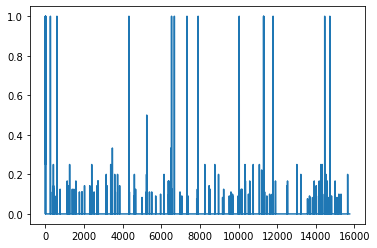

In [7]:
rnn_evals = plot_evals(test, predict_rnn)

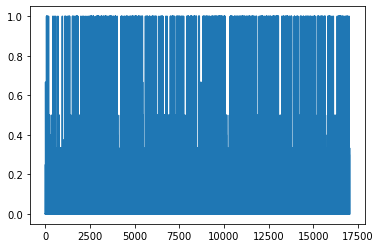

In [8]:
bengio_evals = plot_evals(test, predict_bengio)

In [9]:
for i, score in enumerate(bengio_evals):
    if score != 1 and len(test[i].split(' ')) > 1:
        print(test[i])
        print(predict_bengio[i])
        break

thats the least of your problems.
thats least sir indeed said elizabeth really weird dream fill subconscious grunts


Además recordemos que en la práctica 2 se hace el  análisis para la red de Bengio dando los siguientes resultados:

*Para el entrenamiento con el 10% de las palabras tenemos:*

Entropy: 9.29426577135724

Perplexity: 627.845498555216


*Para el entrenamiento con todo el corpus:*

Entropy: 12.874982418175305

Perplexity: 7512.005574123771

